# Imports

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
cd /content/drive/My Drive/GitHub/emoji2vec

/content/drive/My Drive/GitHub/emoji2vec


In [78]:
!ls data/word2vec

glove-wiki-gigaword-100		     GoogleNews-vectors-negative300.bin
glove-wiki-gigaword-100.vectors.npy


In [79]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import sklearn.manifold as man
from tensorflow.python.framework import ops

from model import Emoji2Vec, ModelParams
from phrase2vec import Phrase2Vec
from utils import build_kb, get_examples_from_kb, generate_embeddings, get_metrics

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initializations
This step takes a while to execute, wait for 'DONE'

## Constants and Hyperparameters

In [80]:
word2vec_path = './data/word2vec/GoogleNews-vectors-negative300.bin'
mapping_path = 'emoji_mapping.p'
data_folder = './data/training/'
embeddings_file = 'generated_embeddings.p'

in_dim = 300   # Length of word2vec vectors
out_dim = 300  # Desired dimension of output vectors
pos_ex = 4
neg_ratio = 1
max_epochs = 40
dropout = 0.1

params = ModelParams(in_dim=in_dim, out_dim=out_dim, pos_ex=pos_ex, max_epochs=max_epochs,
                    neg_ratio=neg_ratio, learning_rate=0.001, dropout=dropout, class_threshold=0.5)


ckpt_path = params.model_folder('unicode') + '/model.ckpt'
e2v_path = 'pre-trained/emoji2vec.bin'
print(ckpt_path, e2v_path)

./results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/model.ckpt pre-trained/emoji2vec.bin


## Build Knowledge Base

In [81]:
print('reading training data from: ' + data_folder)
train_kb, ind2phr, ind2emoj = build_kb(data_folder)

pk.dump(ind2emoj, open(mapping_path, 'wb'))

reading training data from: ./data/training/


In [82]:
for i, (k,v) in enumerate(ind2phr.items()):
    if i%10==9:
        print("{}:{}".format(k,v))
    else:
        print("{}:{}  ".format(k,v),  end="")

0:regional indicator symbol letters sk  1:necktie  2:weather  3:throne  4:scary  5:shared  6:team  7:flag for fiji  8:headphone  9:food
10:machine  11:cancer  12:lungs  13:feet  14:july 17  15:barber shop  16:heavy check mark  17:light brown person with pouting face  18:martini  19:shrugging
20:closed  21:ticket  22:fish  23:heart with arrow  24:oncoming police car  25:dressing  26:cute penguin  27:noodles  28:leaf  29:cutting
30:sight  31:no entry  32:bearskin  33:identification  34:perplex  35:empress  36:white swimmer  37:heavy exclamation mark symbol  38:balloon  39:chat bubble
40:playing cards  41:japanese ogre  42:sign  43:scales  44:flag for indonesia  45:motor cycle  46:leftwards black arrow  47:yellow book  48:pout  49:flag for morocco
50:swiss flag  51:soft  52:earth  53:ferris wheel  54:flag for zambia  55:face with thermometer  56:unlock  57:music  58:cat face with tears of joy  59:put litter in trash
60:alien  61:face  62:regional indicator symbol letters hu  63:leopard  6

In [83]:
for i, (k,v) in enumerate(ind2emoj.items()):
    if i%25==24:
        print("{}:{}".format(k,v))
    else:
        print("{}:{}  ".format(k,v),  end="")

0:🇸🇰  1:👔  2:🌀  3:🚾  4:👹  5:🚻  6:👬  7:🇫🇯  8:🎧  9:🐽  10:🚜  11:♋  12:🚭  13:🚷  14:📅  15:💈  16:✔️  17:🙎🏼  18:🍸  19:🤷  20:🌂  21:🚓  22:🍤  23:💘  24:🚔
25:👚  26:🐧  27:🍥  28:🍵  29:✂️  30:👓  31:⛔  32:💂  33:🆔  34:😕  35:🎎  36:🏊🏻  37:❗  38:💭  39:💬  40:🎴  41:♉  42:⚖  43:🇮🇩  44:🛵  45:⬅️  46:📒  47:😡  48:🇲🇦  49:🇨🇭
50:🍦  51:❗️  52:🌐  53:🎡  54:🇿🇲  55:🤒  56:🔓  57:🎻  58:😹  59:🚮  60:👽  61:🌝  62:🇭🇺  63:🐆  64:🇰🇵  65:💔  66:🎅🏻  67:👇🏽  68:🍆  69:👃🏽  70:🐖  71:😮  72:✴️  73:➗  74:⌚
75:🆎  76:👻  77:🗻  78:🇨🇺  79:😟  80:💣  81:💁  82:🦀  83:🇬🇭  84:🎩  85:🇼  86:👉🏾  87:🙊  88:🍚  89:🍙  90:🚯  91:👩🏿  92:🇫🇷  93:👸🏼  94:😿  95:😲  96:🇲🇰  97:🔢  98:🚬  99:💅
100:🏀  101:🍷  102:🙈  103:👭  104:🍯  105:🏰  106:🖨  107:🍨  108:🆗  109:😩  110:🎉  111:🤐  112:🥡  113:⚫️  114:🏣  115:🌹  116:🌯  117:🎆  118:▶️  119:🔮  120:🙌  121:🆚  122:🙆  123:🎒  124:💆
125:🔰  126:🌜  127:🌕  128:🎑  129:😳  130:⚓  131:🐫  132:♐  133:👂  134:  135:💃  136:🐼  137:🍣  138:🏧  139:🎠  140:🌴  141:😏  142:🛅  143:💶  144:⚽  145:♎  146:🏫  147:😃  148:🇸🇮  149:🔒
150:⛺  151:🚥  152:💵  153:🍺  154:💀  155

## Read or Generate Embeddings

In [84]:
embeddings_array = generate_embeddings(ind2phr=ind2phr, kb=train_kb, embeddings_file=embeddings_file,
                                             word2vec_file=word2vec_path)
print('DONE')

loading embeddings...
DONE


In [85]:
len(embeddings_array[0])

300

## Initialize models and mappings

In [86]:
print('Initializing: reading embedding data from: ' + word2vec_path)
# get the vector for a phrase
phraseVecModel = Phrase2Vec.from_word2vec_paths(params.in_dim, word2vec_path, e2v_path)
print('DONE')

Initializing: reading embedding data from: ./data/word2vec/GoogleNews-vectors-negative300.bin


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


DONE


In [87]:
phraseVecModel['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [88]:
ops.reset_default_graph()

# mapping from id to emoji
mapping = pk.load(open(mapping_path, 'rb'))
# mapping from emoji to id
inv_map = {v: k for k, v in mapping.items()}

# tensorflow model
model = Emoji2Vec(params, len(mapping), embeddings_array=embeddings_array)
print('DONE')

DONE


In [89]:
for i, (k, v) in enumerate(mapping.items()):
    if i%25==24:
        print("{}: {}".format(k,v))
    else:
        print("{}: {}".format(k,v), end='')

0: 🇸🇰1: 👔2: 🌀3: 🚾4: 👹5: 🚻6: 👬7: 🇫🇯8: 🎧9: 🐽10: 🚜11: ♋12: 🚭13: 🚷14: 📅15: 💈16: ✔️17: 🙎🏼18: 🍸19: 🤷20: 🌂21: 🚓22: 🍤23: 💘24: 🚔
25: 👚26: 🐧27: 🍥28: 🍵29: ✂️30: 👓31: ⛔32: 💂33: 🆔34: 😕35: 🎎36: 🏊🏻37: ❗38: 💭39: 💬40: 🎴41: ♉42: ⚖43: 🇮🇩44: 🛵45: ⬅️46: 📒47: 😡48: 🇲🇦49: 🇨🇭
50: 🍦51: ❗️52: 🌐53: 🎡54: 🇿🇲55: 🤒56: 🔓57: 🎻58: 😹59: 🚮60: 👽61: 🌝62: 🇭🇺63: 🐆64: 🇰🇵65: 💔66: 🎅🏻67: 👇🏽68: 🍆69: 👃🏽70: 🐖71: 😮72: ✴️73: ➗74: ⌚
75: 🆎76: 👻77: 🗻78: 🇨🇺79: 😟80: 💣81: 💁82: 🦀83: 🇬🇭84: 🎩85: 🇼86: 👉🏾87: 🙊88: 🍚89: 🍙90: 🚯91: 👩🏿92: 🇫🇷93: 👸🏼94: 😿95: 😲96: 🇲🇰97: 🔢98: 🚬99: 💅
100: 🏀101: 🍷102: 🙈103: 👭104: 🍯105: 🏰106: 🖨107: 🍨108: 🆗109: 😩110: 🎉111: 🤐112: 🥡113: ⚫️114: 🏣115: 🌹116: 🌯117: 🎆118: ▶️119: 🔮120: 🙌121: 🆚122: 🙆123: 🎒124: 💆
125: 🔰126: 🌜127: 🌕128: 🎑129: 😳130: ⚓131: 🐫132: ♐133: 👂134: 135: 💃136: 🐼137: 🍣138: 🏧139: 🎠140: 🌴141: 😏142: 🛅143: 💶144: ⚽145: ♎146: 🏫147: 😃148: 🇸🇮149: 🔒
150: ⛺151: 🚥152: 💵153: 🍺154: 💀155: 🌅156: 🐜157: ♣️158: 🔔159: 🙆🏿160: 💉161: 💯162: 🍕163: 👣164: 🍌165: 🥔166: 🐸167: 👃🏻168: 🍮169: 💞170: 👵🏽171: 🇳🇬172: 🚦173: 🚣174: 💕
175: 🐾176: 🏂177: 👎17

In [90]:
# initialize tensorflow session
session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

INFO:tensorflow:Restoring parameters from ./results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/model.ckpt


# Performance Measures
Check the accuracy, f1 score, auc, and the auc graph

In [0]:
def measures(example_type):
    train_kb, ind2phr, ind2emoj = build_kb(data_folder)
    ex_set = get_examples_from_kb(kb=train_kb, example_type=example_type)

    # evaluate the dev. accuracy using this as the threshold
    thresh = 0.5

    acc = model.accuracy(session=session, dset=ex_set, threshold=thresh)
    f1 = model.f1_score(session=session, dset=ex_set)
    print(str.format('Accuracy at thresh={}: {}', thresh, f1))
    print(str.format('F1 score: {}', f1))
    
    try:
        auc = model.auc(session=session, dset=ex_set)


        print(str.format('AUC score: {}', auc))

        fpr, tpr, thresholds = model.roc_vals(session=session, dset=ex_set)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(fpr, tpr)
        ax.set_title("ROC Curve for learned emoji")
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")

        #
        #for i , val in enumerate(thresholds):
        #    if i % 10 == 0:
        #        plt.annotate(val, (fpr[i], tpr[i]))

        plt.grid()
        plt.show()
    except:
        print('Can\'t compute AUC or ROC')

In [92]:
print('Train Set')
measures('train')

Train Set
Accuracy at thresh=0.5: 0.9933345343181408
F1 score: 0.9933345343181408
Can't compute AUC or ROC


Dev Set
Accuracy at thresh=0.5: 0.7596153846153846
F1 score: 0.7596153846153846
AUC score: 0.906944


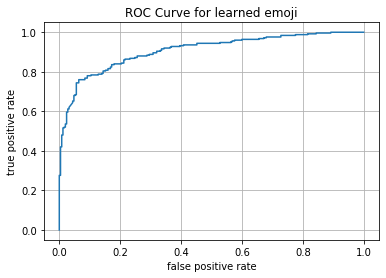

In [93]:
print('Dev Set')
measures('dev')

Test Set
Accuracy at thresh=0.5: 0.812933025404157
F1 score: 0.812933025404157
AUC score: 0.9336160000000001


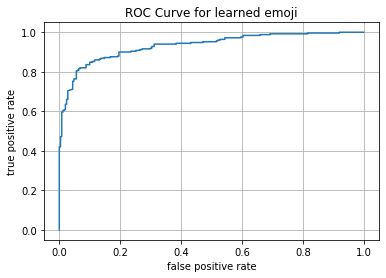

In [94]:
print('Test Set')
measures('test')

In [95]:
# RESET THE GRAPH
ops.reset_default_graph()
model = Emoji2Vec(params, len(mapping), embeddings_array=None, use_embeddings=False)

session = tf.Session()
saver = tf.train.Saver()
saver.restore(session, ckpt_path)

INFO:tensorflow:Restoring parameters from ./results/unicode/k-300_pos-4_rat-1_ep-40_dr-1/model.ckpt


# Top Emoji Query
Set `phr` as a phrase, and get the top `N` emojis correlating to that phrase.

In [96]:
phr = 'boy'
N = 5

# get the vector representaiton
vec = phraseVecModel[phr]

# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([vec])
    })
    res.append(predict)

# print the top N emoji
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

👦 [0.96924365]
👪 [0.9495553]
👴 [0.94784045]
🐤 [0.9475959]
👧 [0.94084615]


# Phrase to Emoji Sequence

In [97]:
phr = 'The pen is stronger than the weapon'

# get the vector representaitons
vecs = phraseVecModel.get_vecs(phr)

# query the tensorflow model
for vec in vecs:
        res = list()
        for colIx in range(0, len(mapping)):
                predict = session.run(model.prob, feed_dict={
                        model.col: np.array([colIx]),
                        model.orig_vec: np.array([vec])
                })
                res.append(predict)
        ind = sorted(range(len(res)), key=lambda i: res[i], reverse=True)[0]
        if res[ind]>0.8:
                print(mapping[ind], res[ind])
        else:
                print("unknown")

unknown
🔏 [0.95721096]
unknown
💪 [0.91662616]
unknown
unknown
🔫 [0.90203434]


In [109]:
phr = 'Alice was beginning to get very tired of sitting by her sister on the bank , and of having nothing to do : once or twice she had peeped into the book her sister was reading'

# get the vector representaitons
vecs = phraseVecModel.get_vecs(phr)

# query the tensorflow model
for vec in vecs:
        res = list()
        for colIx in range(0, len(mapping)):
                predict = session.run(model.prob, feed_dict={
                        model.col: np.array([colIx]),
                        model.orig_vec: np.array([vec])
                })
                res.append(predict)
        ind = sorted(range(len(res)), key=lambda i: res[i], reverse=True)[0]
        if res[ind]>0.9:
                print(mapping[ind], res[ind])
        else:
                print("unknown")

unknown
unknown
unknown
unknown
unknown
😩 [0.98720086]
unknown
unknown
unknown
👭 [0.9633084]
🔛 [0.92736006]
unknown
🏧 [0.98918545]
unknown
🙅 [0.9299516]
unknown
unknown
unknown
unknown
unknown
unknown
🚪 [0.9310162]
🔙 [0.9221477]
unknown
📕 [0.9891677]
unknown
👵 [0.97936]
unknown
unknown


# Top Phrase Query
Set `em` as an emoji, and get the top `N` phrases correlating to that emoji.

In [0]:
# input
em = '👦'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
vec = emoji_vecs[inv_map[em]]

# print top N phrases
for word, score in phraseVecModel.from_emoji([vec], top_n=N):
    print(str.format("{}\t{}", word, score))

# Analogy Task
Set `base` as a base emoji, `minus` as an emoji to subtract from the base, `plus` as an emoji to add, and get the top `N` correlating phrases and emojis relating to this analogy. 

In [0]:
def print_analogy_result(base, minus, plus):
    emoji_vecs = session.run(model.V)
    total = phraseVecModel[base] - phraseVecModel[minus] + phraseVecModel[plus]
    
    res = list()
    for colIx in range(0, len(mapping)):
        predict = session.run(model.prob, feed_dict={
            model.col: np.array([colIx]),
            model.orig_vec: np.array([total / np.linalg.norm(total)])
        })
        res.append(predict)
        
    ems = sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:5]
    print(str.format('{} - {} + {} = {}', base, minus, plus, [mapping[em] for em in ems]))

In [0]:
print_analogy_result('👑', '🚹', '🚺')
print_analogy_result('💵', '🇺🇸', '🇬🇧')
print_analogy_result('💵', '🇺🇸', '🇪🇺')
print_analogy_result('👦', '👨', '👩')
print_analogy_result('👪', '👦', '👧')
print_analogy_result('🕶', '☀️', '⛈')

In [0]:
# input
base = '👑'
# base = '👨'
minus = '🚹'
plus = '🚺'
N = 10

# get the relevant vectors from tensorflow
emoji_vecs = session.run(model.V)
total = emoji_vecs[inv_map[base]] - emoji_vecs[inv_map[minus]] + emoji_vecs[inv_map[plus]]

# print the top N phrases
print(str.format('Top {} mーーatching phrases:', N))
print()
for word, score in phraseVecModel.from_emoji([total], top_n=N):
    print(str.format("{}\t{}", word, score))
    
# query the tensorflow model
res = list()
for colIx in range(0, len(mapping)):
    predict = session.run(model.prob, feed_dict={
        model.col: np.array([colIx]),
        model.orig_vec: np.array([total / np.linalg.norm(total)])
    })
    res.append(predict)

# print the top N emoji
print()
print(str.format('Top {} matching emoji:', N))
print()
for ind in sorted(range(len(res)), key=lambda i: res[i], reverse=True)[:N]:
    print(mapping[ind], res[ind])

# Visualize Emoji Vector Space
2-D projection of the Emoji vector space, using t-SNE.

Jupyter won't plot emoji. Use visualize.py to see a clearer picture.

In [0]:
V = session.run(model.V)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
tsne = man.TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
trans = tsne.fit_transform(V)
x, y = zip(*trans)
plt.scatter(x, y)

for i in range(len(trans)):
    ax.annotate(mapping[i], xy=trans[i], textcoords='data')

plt.grid()
plt.show()